<img src="../images/esgf.png" width=250 alt="CMIP6 image"></img>
<img src="../images/cmip6-cookbook-thumbnail.png" width=250 alt="CMIP6 image"></img>

# Search and Load CMIP6 Data via ESGF/OPeNDAP

---

## Overview

This notebook shows how to search and load data via [Earth System Grid Federation](https://esgf.llnl.gov) infrastructure. This infrastructure works great and is the foundation of the CMIP6 distribution system.

The main technologies used here are the [ESGF search API](https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API), used to figure out what data we want, and [OPeNDAP](https://www.opendap.org/), a remote data access protocol over HTTP.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 10 minutes

---

## Imports

In [1]:
import warnings

from distributed import Client
import holoviews as hv
import hvplot.xarray
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pyesgf.search import SearchConnection
import xarray as xr

xr.set_options(display_style='html')
warnings.filterwarnings("ignore")
hv.extension('bokeh')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 122.83 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42627,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 122.83 GiB
Comm: tcp://127.0.0.1:34501,Total threads: 4
Dashboard: http://127.0.0.1:35105/status,Memory: 15.35 GiB
Nanny: tcp://127.0.0.1:45109,


## Search using ESGF API

Fortunately, there is an ESGF API implemented in Python - `pyesgf`, which requires three major steps:
- Establish a search connection
- Query your data
- Extract the urls to your data

Once you have this information, you can load the data into an `xarray.Dataset`.

### Configure the connection to a data server
First, we configure our connection to some server, using the distributed option (`distrib=False`). In this case, we are searching from the Lawerence Livermore National Lab (LLNL) data node.

In [3]:
conn = SearchConnection('https://esgf-node.llnl.gov/esg-search',
                        distrib=False)

### Query our dataset
We are interested in a single experiment from CMIP6 - one of the Community Earth System Model version 2 (CESM2) runs, specifically the historical part of the simulation.

We are also interested in a single variable - temperature at the surface (**tas**), with a single ensemble member (`r10i1p1f1`)

In [4]:
ctx = conn.new_context(
    facets='project,experiment_id',
    project='CMIP6',
    table_id='Amon',
    institution_id="NCAR",
    experiment_id='historical',
    source_id='CESM2',
    variable='tas',
    variant_label='r10i1p1f1',
)

### Extract the OpenDAP urls
In order to access the datasets, we need the urls to the data. Once we have these, we can read the data remotely!

In [5]:
result = ctx.search()[0]
files = result.file_context().search()
files

The files object is not immediately helpful - we need to extract the `opendap_url` method from this.

In [6]:
files[0].opendap_url

'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_185001-189912.nc'

We can use this for the whole list using list comprehension, as shown below.

In [7]:
opendap_urls = [file.opendap_url for file in files]
opendap_urls

['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_185001-189912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_190001-194912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_195001-199912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_200001-201412.nc']

## Read the data into an `xarray.Dataset`
Now that we have our urls to the data, we can use open multifile dataset (`open_mfdataset`) to read the data, combining the coordinates and chunking by time.

Xarray, together with the netCDF4 Python library, allow lazy loading.

In [8]:
ds = xr.open_mfdataset(opendap_urls,
                       combine='by_coords',
                       chunks={'time':480})
ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, time: 1980, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    time_bnds  (time, nbnd) object dask.array<chunksize=(480, 2), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(600, 288, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(480, 192, 288), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0
    branch_time_in_parent:           306600.0
    case_id:                         24
    ...                              ...
    table_id:                        Amon
    tracking_id:                     hdl:21.14100/e47b79db-3925-45a7-9c0a-679...
    variable_id:                     tas
    variant_info:                    CMIP6 20th century experiments (1850-201...
    variant_label:                   r10i1p1f1
    DODS_EXTRA.Unlimited_Dimension:  time

### Plot a quick look of the data
Now that we have the dataset, let's plot a few quick looks of the data.

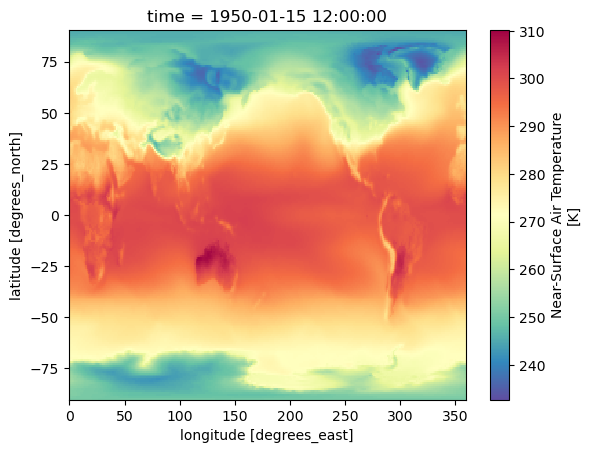

In [9]:
ds.tas.sel(time='1950-01').squeeze().plot(cmap='Spectral_r');

These are OPeNDAP endpoints. Xarray, together with the netCDF4 Python library, allow lazy loading.

## Compute an area-weighted global average
Let's apply some computation to this dataset. We would like to calculate the global average temperature. This requires weighting each of the grid cells properly, using the area.

### Find the area of the cells

We can query the dataserver again, this time extracting the area of the cell (`areacella`).

In [10]:
ctx = conn.new_context(
    facets='project,experiment_id',
    project='CMIP6',
    institution_id="NCAR",
    experiment_id='historical',
    source_id='CESM2',
    variable='areacella',
)

As before, we extract the opendap urls.

In [11]:
result = ctx.search()[0]
files = result.file_context().search()
opendap_urls = [file.opendap_url for file in files]
opendap_urls

['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/fx/areacella/gn/v20190514/areacella_fx_CESM2_historical_r11i1p1f1_gn.nc']

And finally, we load our cell area file into an `xarray.Dataset`

In [12]:
ds_area = xr.open_dataset(opendap_urls[0])
ds_area

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float64 ...
    lon_bnds   (lon, nbnd) float64 ...
    areacella  (lat, lon) float32 ...
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               fx
    tracking_id:            hdl:21.14100/96455df2-979e-4cd4-8521-ddf307c6bc4a
    variable_id:            areacella
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

### Compute the global average
Now that we have the area of each cell, and the temperature at each point, we can compute the global average temperature.

In [13]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
ta_timeseries

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(480,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

By default the data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

In [14]:
%time ta_timeseries.load()

CPU times: user 578 ms, sys: 86.7 ms, total: 665 ms
Wall time: 10.6 s


<xarray.DataArray (time: 1980)>
array([284.99948, 285.23215, 285.85364, ..., 288.54376, 287.61884,
       287.06284], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

### Visualize our results
Now that we have our results, we can visualize using static and dynamic plots. Let's start with static plots using `matplotlib`, then dynamic plots using `hvPlot`.

In [15]:
ta_timeseries['time'] = ta_timeseries.indexes['time'].to_datetimeindex()

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

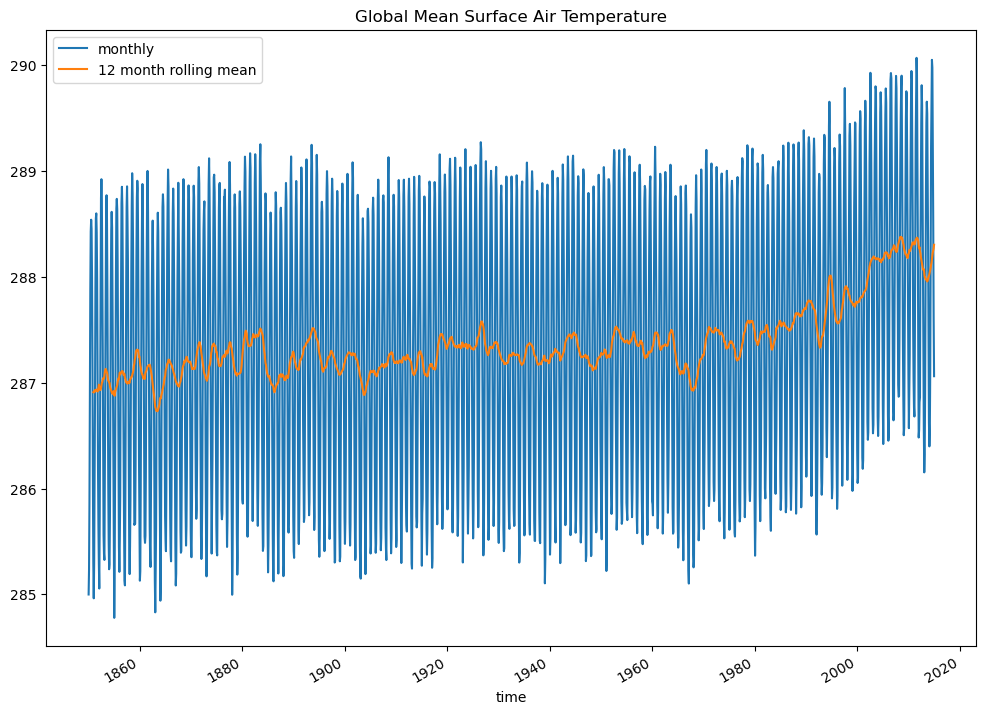

In [16]:
fig = plt.figure(figsize=(12,8))
ta_timeseries.plot(label='monthly')
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')

In [17]:
ta_timeseries.name = 'Temperature (K)'
monthly_average = ta_timeseries.hvplot(title = 'Global Mean Surface Air Temperature',
                                       label='monthly')
rolling_monthly_average = ta_timeseries.rolling(time=12).mean().hvplot(label='12 month rolling mean',)

(monthly_average * rolling_monthly_average).opts(legend_position='top_left')

:Overlay
   .Curve.Monthly                 :Curve   [time]   (Temperature (K))
   .Curve.A_12_month_rolling_mean :Curve   [time]   (Temperature (K))

---

## Summary
In this notebook, we searched for and opened a CESM2 dataset using the ESGF API and OPeNDAP. We then plotted global average surface air temperature.

### What's next?
We will see some more advanced examples of using the CMIP6 data.

## Resources and references
- [Original notebook in the Pangeo Gallery](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/search_and_load_with_esgf_opendap.html) by Henri Drake and [Ryan Abernathey](https://ocean-transport.github.io/)